In [ ]:
from fenics import *
import matplotlib.pyplot as plt

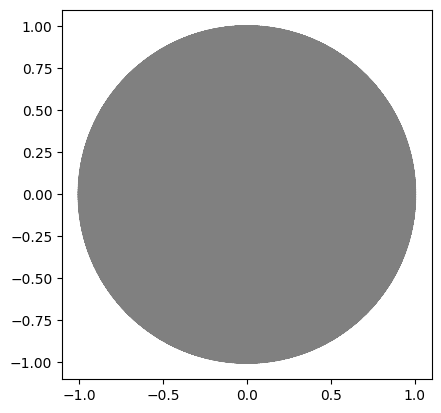

In [54]:
filename = "meshCircle"
mesh = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh, filename + "_physical_region.xml")
plot(mesh)

Solving linear variational problem.


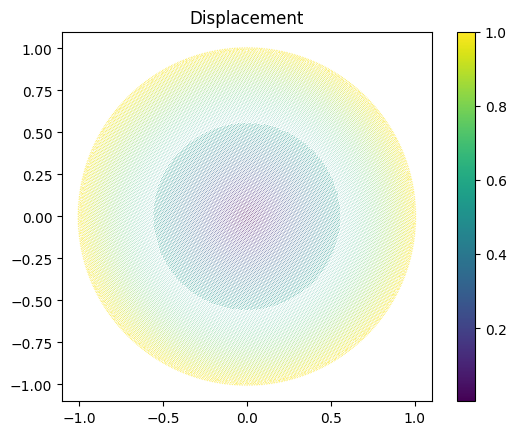

In [49]:
# Scaled variables
E = 21e6
nu = 0.3
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))

# Create mesh and define function space
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol
g = Expression(("x[0]/sqrt(x[0]*x[0]+x[1]*x[1])", "x[1]/sqrt(x[0]*x[0]+x[1]*x[1])"), degree=2)
bc = DirichletBC(V, g, bounds,1)

# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
sol = plot(u, title='Displacement')#, mode='displacement')
plt.colorbar(sol)

# # Plot stress
# s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
# von_Mises = sqrt(3./2*inner(s, s))
# V = FunctionSpace(mesh, 'P', 1)
# von_Mises = project(von_Mises, V)
# plot(von_Mises, title='Stress intensity')

# Compute magnitude of displacement
# u_magnitude = sqrt(dot(u, u))
# u_magnitude = project(u_magnitude, V)
# plot(u_magnitude, 'Displacement magnitude')
# print('min/max u:',
#       u_magnitude.vector().min(),
#       u_magnitude.vector().max())

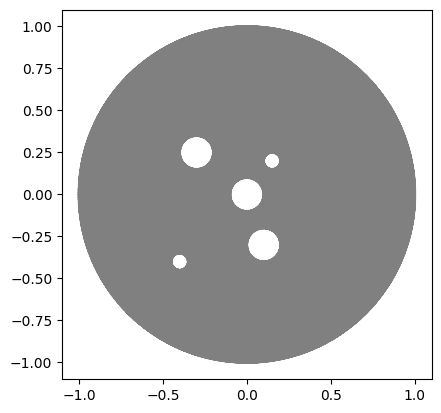

In [56]:
plot(mesh_init)

Solving linear variational problem.


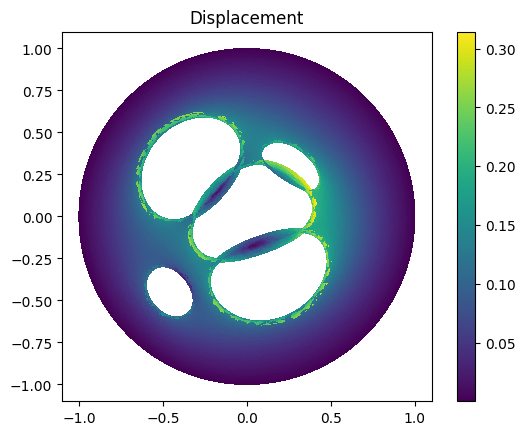

In [57]:

# Create mesh and define function space
filename = "mesh"
mesh_init = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh_init, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh_init, filename + "_physical_region.xml")
V = VectorFunctionSpace(mesh_init, 'P', 1)

bc = []#DirichletBC(V, Constant((0,0)), bounds, 1)

# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u2 = TrialFunction(V)
v2 = TestFunction(V)
# uh = interpolate(u, V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
# utest = Expression(("x[0]/5", "x[1]/5"), degree=2)
uh = interpolate(u, V)
a = inner(sigma(u2), epsilon(v2))*dx
L = -inner(sigma(uh), epsilon(v2))*dx

# Compute solution
u2 = Function(V)
solve(a == L, u2, bc)

# Plot solution
sol = plot(u2, title='Displacement', mode='displacement')
plt.colorbar(sol)


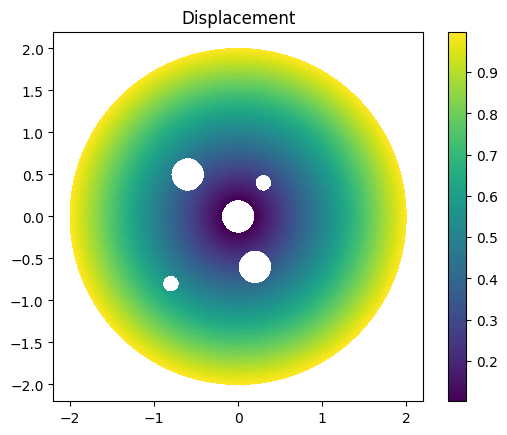

In [45]:
uh = interpolate(u, V)
sol = plot(uh, title='Displacement', mode='displacement')
plt.colorbar(sol)

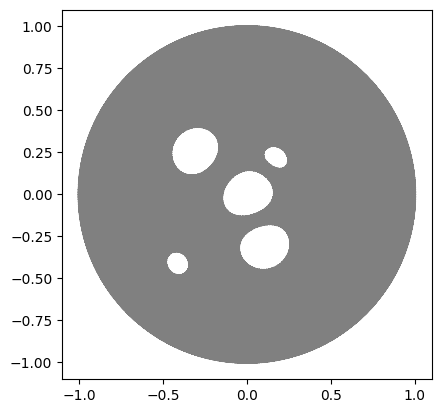

In [18]:
ALE.move(mesh, u2)
plot(mesh)

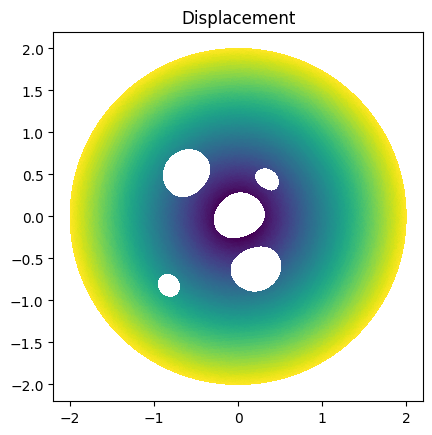

In [19]:
utest = Expression(("x[0]", "x[1]"), degree=2)
utest = interpolate(utest, V)
plot(utest, title='Displacement', mode='displacement')


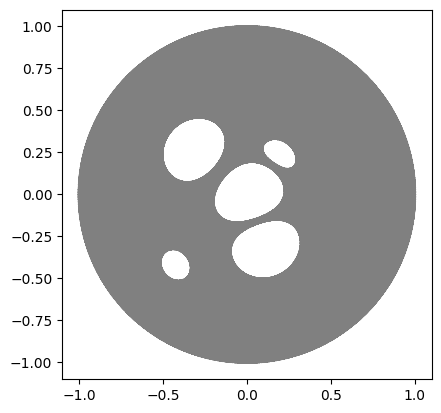

In [20]:
ALE.move(mesh, u2)
plot(mesh)

6.283185306759798


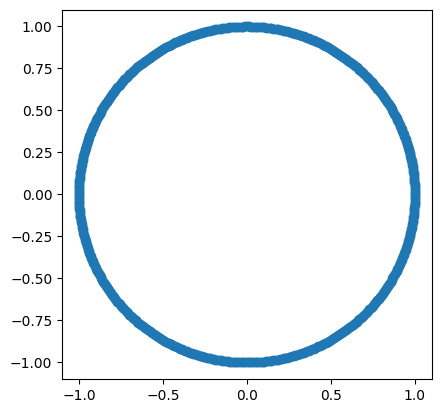

In [24]:
# curvature 
import numpy
import dolfin
from dolfin import *


def mesh_to_boundary(v, b_mesh):
    """
    Returns a the boundary representation of the CG-1 function v
    """
    # Extract the underlying volume and boundary meshes
    mesh = v.function_space().mesh()

    # We use a Dof->Vertex mapping to create a global
    # array with all DOF values ordered by mesh vertices
    DofToVert = dolfin.dof_to_vertex_map(v.function_space())
    VGlobal = numpy.zeros(v.vector().size())

    vec = v.vector().get_local()
    for i in range(len(vec)):
        Vert = dolfin.MeshEntity(mesh, 0, DofToVert[i])
        globalIndex = Vert.global_index()
        VGlobal[globalIndex] = vec[i]
    VGlobal = SyncSum(VGlobal)

    # Use the inverse mapping to se the DOF values of a boundary
    # function
    surface_space = dolfin.FunctionSpace(b_mesh, "CG", 1)
    surface_function = dolfin.Function(surface_space)
    mapa = b_mesh.entity_map(0)
    DofToVert = dolfin.dof_to_vertex_map(dolfin.FunctionSpace(b_mesh, "CG", 1))

    LocValues = surface_function.vector().get_local()
    for i in range(len(LocValues)):
        VolVert = dolfin.MeshEntity(mesh, 0, mapa[int(DofToVert[i])])
        GlobalIndex = VolVert.global_index()
        LocValues[i] = VGlobal[GlobalIndex]

    surface_function.vector().set_local(LocValues)
    surface_function.vector().apply('')
    return surface_function

def vector_mesh_to_boundary(func, b_mesh):
    v_split = func.split(deepcopy=True)
    v_b = []
    for v in v_split:
        v_b.append(mesh_to_boundary(v, b_mesh))
    Vb = dolfin.VectorFunctionSpace(b_mesh, "CG", 1)
    vb_out = dolfin.Function(Vb)
    scalar_to_vec = dolfin.FunctionAssigner(Vb, [v.function_space() for
                                                  v in v_b])
    scalar_to_vec.assign(vb_out, v_b)
    return vb_out


def SyncSum(vec):
    """ Returns sum of vec over all mpi processes.
    Each vec vector must have the same dimension for each MPI process """

    comm = dolfin.MPI.comm_world
    NormalsAllProcs = numpy.zeros(comm.Get_size() * len(vec), dtype=vec.dtype)
    comm.Allgather(vec, NormalsAllProcs)

    out = numpy.zeros(len(vec))
    for j in range(comm.Get_size()):
        out += NormalsAllProcs[len(vec) * j:len(vec) * (j + 1)]
    return out

def boundary_to_mesh(f, mesh):
    b_mesh = f.function_space().mesh()
    SpaceV = dolfin.FunctionSpace(mesh, "CG", 1)
    SpaceB = dolfin.FunctionSpace(b_mesh, "CG", 1)

    F = dolfin.Function(SpaceV)
    GValues = numpy.zeros(F.vector().size())

    map = b_mesh.entity_map(0)  # Vertex map from boundary mesh to parent mesh
    d2v = dolfin.dof_to_vertex_map(SpaceB)
    v2d = dolfin.vertex_to_dof_map(SpaceV)

    dof = SpaceV.dofmap()
    imin, imax = dof.ownership_range()

    for i in range(f.vector().local_size()):
        GVertID = dolfin.Vertex(b_mesh, d2v[i]).index()  # Local Vertex ID for given dof on boundary mesh
        PVertID = map[GVertID]  # Local Vertex ID of parent mesh
        PDof = v2d[PVertID]  # Dof on parent mesh
        value = f.vector()[i]  # Value on local processor
        GValues[dof.local_to_global_index(PDof)] = value
    GValues = SyncSum(GValues)

    F.vector().set_local(GValues[imin:imax])
    F.vector().apply("")
    return F


mesh = Mesh(UnitDiscMesh.create(MPI.comm_world, 100, 1, 2))
# plot(mesh)
n = FacetNormal(mesh)
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
a = inner(u,v)*ds
l = inner(n, v)*ds
A = assemble(a, keep_diagonal=True)
L = assemble(l)

A.ident_zeros()
nh = Function(V)

solve(A, nh.vector(), L)
File("nh.pvd") << nh
bmesh = BoundaryMesh(mesh, "exterior")
plot(bmesh)
nb = vector_mesh_to_boundary(nh, bmesh)
Q = FunctionSpace(bmesh, "CG", 1)

p, q = TrialFunction(Q), TestFunction(Q)
a = inner(p,q)*dx
l = inner(div(nb), q)*dx
A = assemble(a, keep_diagonal=True)
L = assemble(l)
A.ident_zeros()
kappab = Function(Q)
solve(A, kappab.vector(), L)
kappa = boundary_to_mesh(kappab, mesh)

print(assemble(kappa*ds))